<a href="https://colab.research.google.com/github/hoveidar/Neural-Network-Pruning/blob/master/for_ai_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pruning on Neural Networks



Note: Please save this code in your Google Drive account and run it cell by cell from the begining till the end (sequentially).

## Importing required libraries
Let's import required libraries:

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals
import random


# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# scikit-learn and pandas for preprocessing and showing results
from sklearn import preprocessing
import pandas as pd


print(tf.__version__)

1.14.0


## Dataset -> Fashion-MNIST

We are going to use Fashion-MNIST dataset in this project.

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
# Let's define train and test sets
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Below is a list of all classes avaiable in our dataset:

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Let's see how does a random instance of the train set looks like:

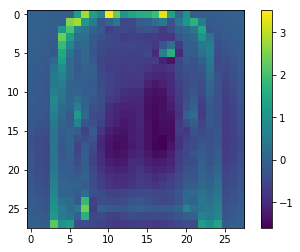

In [18]:
pic_instance = random.randint(0,len(train_images))
plt.figure()
plt.imshow(train_images[pic_instance])
plt.colorbar()
plt.grid(False)
plt.show()

## Preprocessing (normalization)

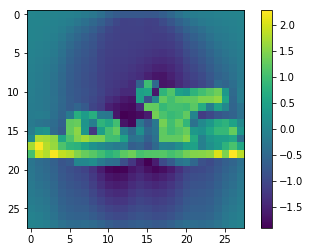

In [15]:
train_images = train_images.reshape((-1,28*28))
test_images = test_images.reshape((-1,28*28))
# we use standard scaler method from sklearn dataset for normalization of the
# train dataset
scaler = preprocessing.StandardScaler().fit(train_images)



train_images = scaler.transform(train_images)

# we used the same transformation to scale the test set
test_images = scaler.transform(test_images)

train_images = train_images.reshape((-1,28,28))
test_images = test_images.reshape((-1,28,28))

plt.figure()
plt.imshow(train_images[pic_instance])
plt.colorbar()
plt.grid(False)
plt.show()


## Neural Network Model initialization

In [0]:
# We initialize a fully connected NN using the requirements of the assignment
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(1000, activation=tf.nn.relu,use_bias=False),
    keras.layers.Dense(1000, activation=tf.nn.relu,use_bias=False),
    keras.layers.Dense(500, activation=tf.nn.relu,use_bias=False),
    keras.layers.Dense(200, activation=tf.nn.relu,use_bias=False),
    keras.layers.Dense(10, activation=tf.nn.softmax,use_bias=False)
])

In [0]:
# Let's compile our model

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train model

In [32]:
# Here, we train our model on our train set
model.fit(train_images, train_labels, epochs=7)

Epoch 1/7
60000/60000 [==============================] - 60s 1ms/sample - loss: 0.4732 - acc: 0.8312
Epoch 2/7
60000/60000 [==============================] - 59s 988us/sample - loss: 0.3612 - acc: 0.8697
Epoch 3/7
60000/60000 [==============================] - 59s 989us/sample - loss: 0.3232 - acc: 0.8843
Epoch 4/7
60000/60000 [==============================] - 61s 1ms/sample - loss: 0.2972 - acc: 0.8920
Epoch 5/7
60000/60000 [==============================] - 60s 992us/sample - loss: 0.2772 - acc: 0.8986
Epoch 6/7
60000/60000 [==============================] - 60s 992us/sample - loss: 0.2577 - acc: 0.9049
Epoch 7/7
60000/60000 [==============================] - 59s 984us/sample - loss: 0.2428 - acc: 0.9107


In [0]:
# Let's save our model
keras.models.save_model(
    model,
    './model',
    overwrite=True,
    include_optimizer=True,
    save_format=None
)

## Model evaluation on the test set (Before pruning)

In [35]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy after training:', test_acc)



10000/10000 [==============================] - 3s 261us/sample - loss: 0.3672 - acc: 0.8751
Test accuracy after training: 0.8751


##  Weight pruning

In [36]:

####################################################################
#defining a function for weight pruning


def weight_pruning(W,k):
  
  # number of Weight matrices
  W_count = np.shape(W)[0]

  for layer in range(W_count-1): # (W_count-1) is used to prevent pruning of output layer
    temp = W[layer]
    temp_shape = temp.shape
    temp_flatten = temp.reshape(temp_shape[0]*temp_shape[1],)

    temp_abs = np.abs(temp_flatten)

    ind = np.argsort(temp_abs)
    prune_ind = ind[0:int(k*len(ind))]
    for i in prune_ind:
      temp_flatten[i] = 0
    W[layer] = temp_flatten.reshape(temp_shape)
  return W
####################################################################

weight_based_results = pd.DataFrame() # dataframe to save results for different k values

for k in [.0, .25, .50, .60, .70, .80, .90, .95, .97, .99]:
  # let's load our saved model
  new_model = keras.models.load_model(
      './model',
      custom_objects=None,
      compile=True
  )
  
  # getting weights of the model
  main_weights = new_model.get_weights()
  # setting new weights in the network
  new_weights = weight_pruning(main_weights,k)
  new_model.set_weights(new_weights)



  # evaluating new_model performance after pruning
  new_test_loss, new_test_acc = new_model.evaluate(test_images, test_labels)

  print('Test accuracy after weight pruning of %.2f:'%k, new_test_acc)
  k_step_result = pd.DataFrame({
      'k': [k],
      'Accuracy_weight_based_pruning': [new_test_acc]
  })
  weight_based_results = pd.concat([weight_based_results,k_step_result],axis=0)
  


10000/10000 [==============================] - 3s 276us/sample - loss: 0.3672 - acc: 0.8751
Test accuracy after weight pruning of 0.00: 0.8751
10000/10000 [==============================] - 3s 267us/sample - loss: 0.3643 - acc: 0.8749
Test accuracy after weight pruning of 0.25: 0.8749
10000/10000 [==============================] - 3s 263us/sample - loss: 0.3594 - acc: 0.8758
Test accuracy after weight pruning of 0.50: 0.8758
10000/10000 [==============================] - 3s 269us/sample - loss: 0.3624 - acc: 0.8742
Test accuracy after weight pruning of 0.60: 0.8742
10000/10000 [==============================] - 3s 272us/sample - loss: 0.3780 - acc: 0.8720
Test accuracy after weight pruning of 0.70: 0.872
10000/10000 [==============================] - 3s 273us/sample - loss: 0.4575 - acc: 0.8582
Test accuracy after weight pruning of 0.80: 0.8582
10000/10000 [==============================] - 3s 275us/sample - loss: 0.9321 - acc: 0.7897
Test accuracy after weight pruning of 0.90: 0.7897


### Weight pruning results

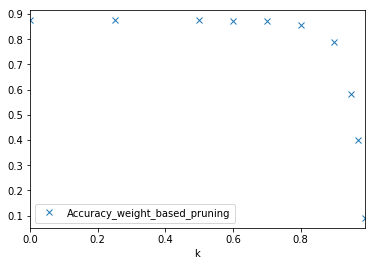

In [37]:
weight_based_results.plot(x='k',y='Accuracy_weight_based_pruning',style='x')


In [40]:
weight_based_results

,k,Accuracy_weight_based_pruning
0,0.00,0.8751
0,0.25,0.8749
0,0.50,0.8758
0,0.60,0.8742
0,0.70,0.8720
0,0.80,0.8582
0,0.90,0.7897
0,0.95,0.5837
0,0.97,0.3991
0,0.99,0.0904


## Unit pruning

In [38]:
####################################################################
#defining a function for unit pruning


def unit_pruning(W,k):
  
  # number of Weight matrices
  W_count = np.shape(W)[0]

  for layer in range(W_count-1): # (W_count-1) is used to prevent pruning of output layer
    temp = W[layer]
    temp_shape = temp.shape
#     temp_flatten = temp.reshape(temp_shape[0]*temp_shape[1],)
    temp_norm = np.linalg.norm(temp,axis=0)

#     temp_abs = np.abs(temp_flatten)

    ind = np.argsort(temp_norm)
    prune_ind = ind[0:int(k*len(ind))]
    for i in prune_ind:
      temp[:,i] = 0
      
      
    W[layer] = temp
  return W
####################################################################

unit_based_results = pd.DataFrame() # dataframe to save results for different k values

for k in [.0, .25, .50, .60, .70, .80, .90, .95, .97, .99]:
  # let's load our saved model
  new_model = keras.models.load_model(
      './model',
      custom_objects=None,
      compile=True
  )
  
  # getting weights of the model
  main_weights = new_model.get_weights()
  # setting new weights in the network
  new_weights = unit_pruning(main_weights,k)
  new_model.set_weights(new_weights)

  # evaluating new_model performance after pruning
  new_test_loss, new_test_acc = new_model.evaluate(test_images, test_labels)

  print('Test accuracy after unit pruning of %.2f:'%k, new_test_acc)
  k_step_result = pd.DataFrame({
      'k': [k],
      'Accuracy_unit_based_pruning': [new_test_acc]
  })
  unit_based_results = pd.concat([unit_based_results,k_step_result],axis=0)

10000/10000 [==============================] - 3s 272us/sample - loss: 0.3672 - acc: 0.8751
Test accuracy after unit pruning of 0.00: 0.8751
10000/10000 [==============================] - 3s 267us/sample - loss: 0.3617 - acc: 0.8754
Test accuracy after unit pruning of 0.25: 0.8754
10000/10000 [==============================] - 3s 276us/sample - loss: 0.3673 - acc: 0.8692
Test accuracy after unit pruning of 0.50: 0.8692
10000/10000 [==============================] - 3s 271us/sample - loss: 0.3786 - acc: 0.8648
Test accuracy after unit pruning of 0.60: 0.8648
10000/10000 [==============================] - 3s 256us/sample - loss: 0.5203 - acc: 0.7822
Test accuracy after unit pruning of 0.70: 0.7822
10000/10000 [==============================] - 3s 283us/sample - loss: 1.0684 - acc: 0.7038
Test accuracy after unit pruning of 0.80: 0.7038
10000/10000 [==============================] - 3s 270us/sample - loss: 2.1690 - acc: 0.2266
Test accuracy after unit pruning of 0.90: 0.2266
10000/10000 [

### Unit pruning results

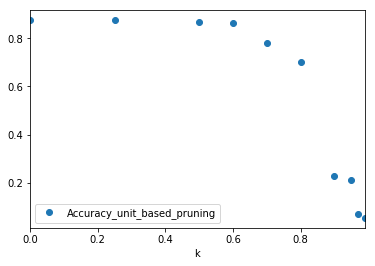

In [39]:
unit_based_results.plot(x='k',y='Accuracy_unit_based_pruning',style='o')


In [41]:
unit_based_results

,k,Accuracy_unit_based_pruning
0,0.00,0.8751
0,0.25,0.8754
0,0.50,0.8692
0,0.60,0.8648
0,0.70,0.7822
0,0.80,0.7038
0,0.90,0.2266
0,0.95,0.2106
0,0.97,0.0716
0,0.99,0.0533


## Conclusion

Based on the resluts of this experiment, we can observe that the accuracy with Weight pruning drops with much higher k values in comparison with Unit pruning technique. This suggests that the network performance is more stable using Weight pruning than Unit pruning. This might be due to the fact that Unit pruning is a very aggressive procedure in comparison with the other approach. In other words, when we try to delete (prune) a unit altogether, we might lose all the good connections it has, while when we are pruning based only on weights, we are only getting rid of the weights which are not contributing that much to our network (due to their small absolute value). So, in conclusion our neural network would suffer more (accuracy wise) with Unit pruning method and Weight pruning method seems to be a better alternative. The other important aspect of this experiment is that even with 80% of weights being pruned, still we can have good performance in comparison with having all the weights of the network (i.e., k=0.0%). This can be due to the fact that our network has way more parameters (weights) than needed for the afformentioned task (Fashion-MNIST dataset classification task). Therefore, by pruning even a large percentage of the weights we can still get a comparable result to the highest accuracy of the network with all of it's weights.

